In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from lifelines import KaplanMeierFitter
from matplotlib.colors import ListedColormap

### Antecedentes
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1)	unit number

2)	time, in cycles

3)	operational setting 1

4)	operational setting 2

5)	operational setting 3

6)	sensor measurement  1

7)	sensor measurement  2
...
26)	sensor measurement  21

### Exploración de data

In [2]:
tmp_col_names = ['unit_nr', 'time_cycles','op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = tmp_col_names + sensor_names

In [3]:
col_names

['unit_nr',
 'time_cycles',
 'op_setting_1',
 'op_setting_2',
 'op_setting_3',
 's_1',
 's_2',
 's_3',
 's_4',
 's_5',
 's_6',
 's_7',
 's_8',
 's_9',
 's_10',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_16',
 's_17',
 's_18',
 's_19',
 's_20',
 's_21']

In [4]:
current_path = os.getcwd()
train = pd.read_csv((current_path+'/train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((current_path+'/test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((current_path+'/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [6]:
train.head()

,unit_nr,time_cycles,op_setting_1,op_setting_2,op_setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
train[tmp_col_names].describe()

,unit_nr,time_cycles,op_setting_1,op_setting_2,op_setting_3
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0
std,29.227633,68.880990,0.002187,0.000293,0.0
min,1.000000,1.000000,-0.008700,-0.000600,100.0
25%,26.000000,52.000000,-0.001500,-0.000200,100.0
50%,52.000000,104.000000,0.000000,0.000000,100.0
75%,77.000000,156.000000,0.001500,0.000300,100.0
max,100.000000,362.000000,0.008700,0.000600,100.0


Los "operational settings" tienden a ser 0 por lo que no serían variables a considerar

In [8]:
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


Los sensores 1,10,18 y 19 tienen desv. estándar 0 + min y max iguales --> Revisar 

Los sensores 5,6 y 16 tienen desv. estándar <> 0 pero min y max iguales --> Revisar

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_nr       20631 non-null  int64  
 1   time_cycles   20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   s_1           20631 non-null  float64
 6   s_2           20631 non-null  float64
 7   s_3           20631 non-null  float64
 8   s_4           20631 non-null  float64
 9   s_5           20631 non-null  float64
 10  s_6           20631 non-null  float64
 11  s_7           20631 non-null  float64
 12  s_8           20631 non-null  float64
 13  s_9           20631 non-null  float64
 14  s_10          20631 non-null  float64
 15  s_11          20631 non-null  float64
 16  s_12          20631 non-null  float64
 17  s_13          20631 non-null  float64
 18  s_14          20631 non-nu

In [22]:
test.head()

,unit_nr,time_cycles,op_setting_1,op_setting_2,op_setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_nr       13096 non-null  int64  
 1   time_cycles   13096 non-null  int64  
 2   op_setting_1  13096 non-null  float64
 3   op_setting_2  13096 non-null  float64
 4   op_setting_3  13096 non-null  float64
 5   s_1           13096 non-null  float64
 6   s_2           13096 non-null  float64
 7   s_3           13096 non-null  float64
 8   s_4           13096 non-null  float64
 9   s_5           13096 non-null  float64
 10  s_6           13096 non-null  float64
 11  s_7           13096 non-null  float64
 12  s_8           13096 non-null  float64
 13  s_9           13096 non-null  float64
 14  s_10          13096 non-null  float64
 15  s_11          13096 non-null  float64
 16  s_12          13096 non-null  float64
 17  s_13          13096 non-null  float64
 18  s_14          13096 non-nu

In [10]:
y_test.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### Metodología de trabajo

Posterior a revisar la data al ser un dataset con pocas filas (21 mil y 13 mil aprox) y pocas columnas (26) se procederá a generar un modelo predictivo que llevara como benchmark el modelamiento utilizando todas las variables y posterior a eso se explorara la mejor combinación de estas. Si fuera un dataset grande con millones de filas y miles de columnas se aplicaría un proceso diferente ya que primero buscaríamos seleccionar variables para crear un benchmark ya que por temas de recursos/tiempo se busca optimizar las variables que generan mayor explicabilidad y posterior a esto, optimizar el modelo.

### Generando RUL
RUL = tiempo util restante

Buscaremos cual es el maximo ciclo de tiempo para ver el límite de tiempo util a nivel de unidad (columna "max_time_cycle"); y luego dependiendo en el ciclo que vaya la unidad podremos ver "cuantos ciclos" podría quedarle tomando de referencia el máximo descrito anteriormente.

In [5]:
train_copy = train.copy()
test_copy = test.copy()
y_test_copy = y_test.copy()

In [6]:
max_time_cycle = train_copy.groupby(by="unit_nr")["time_cycles"].max()
train_copy = pd.merge(train_copy,max_time_cycle, on="unit_nr")
train_copy = train_copy.rename(columns={'time_cycles_x':'time_cycles','time_cycles_y':'max_time_cycle'})
train_copy['RUL'] = train_copy['max_time_cycle'] - train_copy['time_cycles']
train_copy = train_copy.drop('max_time_cycle', axis=1)
train_copy.head()

,unit_nr,time_cycles,op_setting_1,op_setting_2,op_setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [13]:
train_copy['RUL'].describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

Podemos observar que existe un minimo de 0 tiempo util restante, y un maximo de hasta 361 ciclos

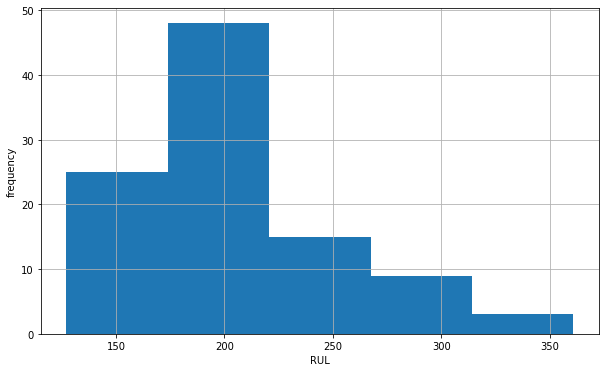

In [301]:
train_copy_max_rul = train_copy[['unit_nr','RUL']].groupby('unit_nr').max().reset_index()
train_copy_max_rul['RUL'].hist(bins=5, figsize=(10,6))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

Esto muestra que la mayoría de las unidades se concentra en 200 ciclos de tiempo util restante (RUL). 

<AxesSubplot:xlabel='time_cycles'>

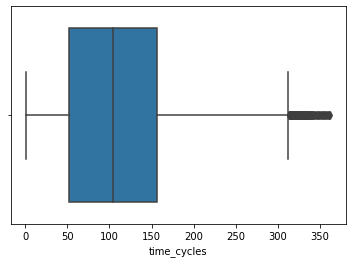

In [565]:
sns.boxplot(x=train_copy['time_cycles'])

El Q1 (0.25 Percentil) esta en los 50 ciclos, y el Q3 (0.75 Percentile) en los 150 ciclos. Con una Mediana de 100 ciclos.

### Benchmark + Selección Variables
KPIS para elección de modelo: 

    1) RMSE (para ver precisión) 

    2) R2 (para ver explicabilidad) 

Pasos a seguir
(La predicción se modelara con regresión lineal y SVR para ver diferencias de performance):

    a) Tomaremos como benchmark una regresión lineal con todas las variables (sensores)
    b) Se analizarán sensores de baja o nula variabilidad en los datos para ver si influeyen
    c) Se re-planteara el benchmark con SVR para ver si performa mejor que la regresión lineal
    d) Posterior a esto, iremos analizando las variables para seleccionar la mejor combinación a determinar en base a mejorar el benchmark del punto c)

### KPI's

In [7]:
#KPIS
def rmse(y,yhat):
    rmse = np.sqrt(mean_squared_error(y,yhat))
    print("rmse: ",rmse)
def r2(y,yhat):
    r2 = r2_score(y,yhat)
    print("R2: ", r2)

### Benchmark

In [567]:
#x_train tendra las variables que usaremos para predecir 
#y_train es nuestra variable a predecir
x_train = train_copy[sensor_names+['RUL']].copy()
y_train = x_train.pop('RUL')

In [522]:
x_train.head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [568]:
#x_test tendra las variables que usamos en la predicción para poder testear (buscamos en que ciclo quedó cada unidad) 
#y_test es nuestra variable real
x_test = test_copy.groupby('unit_nr').last().reset_index()
x_test = x_test[sensor_names].copy()
y_test = y_test_copy.copy()
x_test.head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [569]:
#Generamos la regresion
lm = LinearRegression()
lm.fit(x_train,y_train)
yhat_train = lm.predict(x_train)

In [570]:
#Aplicamos regresion al test
yhat_test = lm.predict(x_test)

In [571]:
#Evaluamos con los kpis mencionados 
print("Testing Benchmark:")
rmse(y_test,yhat_test)
r2(y_test,yhat_test)

Testing Benchmark:
rmse:  31.94977455636664
R2:  0.408879457833612


### Analizando sensores de baja o nula variabilidad

Que pasa si sacamos los sensores que presentan una baja o nula variabilidad (encontrados anteriormente). Recordemos:

Los sensores 1,10,18 y 19 tienen desv. estándar 0 + min y max iguales --> Revisar 

Los sensores 5,6 y 16 tienen desv. estándar <> 0 pero min y max iguales --> Revisar

Se podrían eliminar como variables ya que no generarían diferencia entre unidades

In [572]:
sacar_sensores = ['s_1','s_10','s_18','s_19','s_5','s_6','s_16']

In [573]:
#Nuevas variables de training
x_train = train_copy[sensor_names+['RUL']].copy()
x_train = x_train.drop(sacar_sensores, axis=1)
y_train = x_train.pop('RUL')

#Actualizar variables para test
x_test = test_copy.groupby('unit_nr').last().reset_index()
x_test = x_test[sensor_names].copy()
x_test = x_test.drop(sacar_sensores, axis=1)
y_test = y_test_copy.copy()

In [574]:
#Generamos la regresion
lm = LinearRegression()
lm.fit(x_train,y_train)
yhat_train = lm.predict(x_train)

#Aplicamos regresion al test
yhat_test = lm.predict(x_test)

#Evaluamos con los kpis mencionados 
print("Testing Sacando Sensores con baja o nula variabilidad:")
rmse(y_test,yhat_test)
r2(y_test,yhat_test)

Testing Sacando Sensores con baja o nula variabilidad:
rmse:  31.95263302773748
R2:  0.40877368076590137


Se observa que no cambia en nada la medida, quedandonos con un rmse de 32 aprox. y un r2 de 41%, esto nos muestra que efectivamente las variables que sacamos no proporcionaban ningun peso en la predicción. Por temas de optimización de data (tamaño df) se dejara sin los sensores anteriormente mencionados.

### Normalizacion y modelamiento con SVR
Vamos a normalizar las variables para poder dejarlas todas entre 0 y 1 con el objetivo de estandarizar en una misma escala los sensores:

In [575]:
norm = MinMaxScaler().fit(x_train)
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)

Para una regresión lineal la normalización no causa diferencia, pero esto nos sirve para hacer un nuevo modelamiento con SVR, esto debido a que SVR ve distancias y performa mejor al tener las variables normalizadas (todas entre 0 y 1) ya que podá separar las clases de mejor forma:

In [576]:
#Generamos la SVR
svr = SVR(kernel='linear')
svr.fit(x_train_norm,y_train)
yhat_train = svr.predict(x_train_norm)

#Aplicamos SVR al test
yhat_test = svr.predict(x_test_norm)

#Evaluamos con los kpis mencionados 
print("Testing con SVR con normalización:")
rmse(y_test,yhat_test)
r2(y_test,yhat_test)

Testing con SVR con normalización:
rmse:  26.225204844522718
R2:  0.6017294130737041


Esto nos da por resultado un nuevo modelo que mejora Benchmark debido a que SVR cuenta con una mayor precisión al clasificar las clases (RUL), pasando de un rmse de 32 a 26 y un R2 de 0.4 a 0.6. Así que este será nuestro modelo base (benchmark)

Aún así este modelo sigue siendo una base ya que no se ha aplicado ninguna discriminación de variables.

###  Probabilidad de supervivencia en el tiempo
Existe una metodología para estimar el tiempo hasta el fallo en una máquinaria, ésta consiste en utilizar el indicador de KaplanMeier, ya que nos dirá la probabilidad de "supervivencia" de las unidades a medida que avanzan los ciclos.

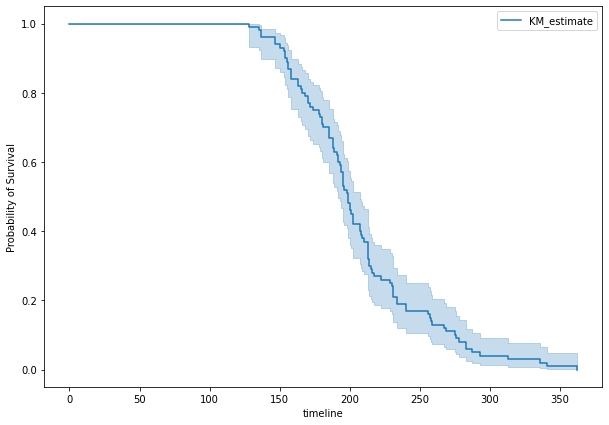

In [16]:
train_copy['failure'] = 0
idx_last_record = train_copy.reset_index().groupby(by='unit_nr')['index'].last()
train_copy.at[idx_last_record, 'failure'] = 1

train_prob = train_copy[['unit_nr','time_cycles','failure']].groupby('unit_nr').last()

plt.figure(figsize=(10,7))
survival = KaplanMeierFitter()
survival.fit(train_prob['time_cycles'], train_prob['failure'])
survival.plot()
plt.ylabel("Probability of Survival")
plt.show()
plt.close()

El resultado es curioso, ya que uno esperaria que a medida que avanzan los ciclos la probabilidad de supervivencia empiece a disminuir de forma "lineal", pero vemos que hay una probabilidad de supervivencia del 100% hasta el ciclo 130. En otras palabras, si definimos la probabilidad de falla como la opuesta a la de supervivencia, podríamos decir que a hasta el ciclo 130 sabemos que la unidad no fallará y en el ciclo 131 empezaríamos a tener probabilidad de falla.

Como el RUL es la definición opuesta de los ciclos que se llevan, podemos tomar este insight para decir que nuestra varible a predecir "RUL" si cuenta con al menos 130 ciclos aún de vida útil tendrá un comportamiento similar (ya que tienen misma probabilidad de supervivencia). 

Veremos si al definir que a partir de 130 todos los RUL son "iguales", para ver si esto cambia en algo nuestras predicciones:

In [31]:
#PREPARACIÓN DE DATA PREVIA:
sacar_sensores = ['s_1','s_10','s_18','s_19','s_5','s_6','s_16']

#Nuevas variables de training
x_train = train_copy[sensor_names+['RUL']].copy()
x_train = x_train.drop(sacar_sensores, axis=1)
y_train = x_train.pop('RUL')

#Actualizar variables para test
x_test = test_copy.groupby('unit_nr').last().reset_index()
x_test = x_test[sensor_names].copy()
x_test = x_test.drop(sacar_sensores, axis=1)
y_test = y_test_copy.copy()

norm = MinMaxScaler().fit(x_train)
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)

In [38]:
#Aplicamos el limite de RUL en base al supuesto obtenido con el indicador de KaplanMeier
y_train_new = y_train.copy()
y_train_new = y_train_new.clip(upper=130)

In [41]:
#Generamos la SVR
svr = SVR(kernel='linear')
svr.fit(x_train_norm,y_train_new)
yhat_train = svr.predict(x_train_norm)

#Aplicamos SVR al test
yhat_test = svr.predict(x_test_norm)

#Evaluamos con los kpis mencionados 
print("Testing con SVR con normalización:")
rmse(y_test,yhat_test)
r2(y_test,yhat_test)

Testing con SVR con normalización:
rmse:  21.593108504025693
R2:  0.7299956320577844


El R2 sube de 0.6 a 0.73 y el rmse disminye de 26.2 21.6, por lo tanto, se tomará el supuesto de que a partir de un RUL de 130 las unidades tienen un mismo comportamiento.

### Combinación de variables

#### Correlación
Se vera la correlación como input para ver que variables utilizar. 

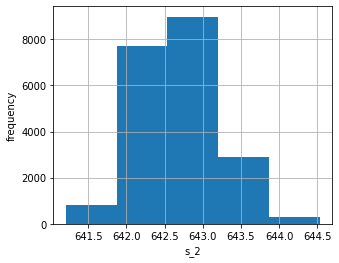

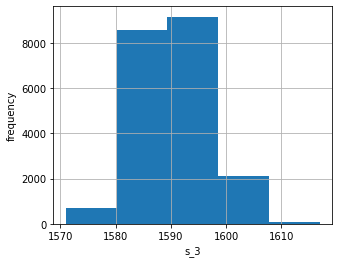

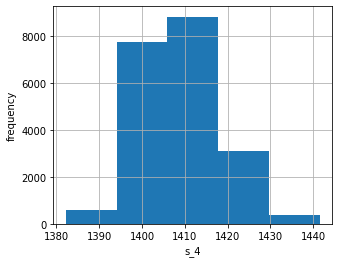

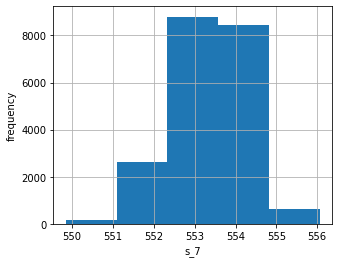

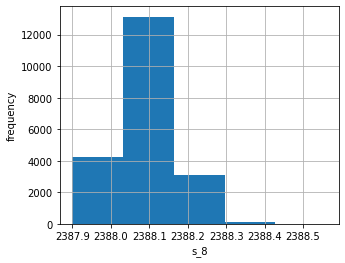

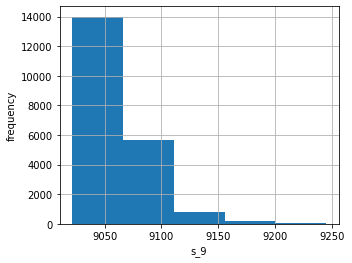

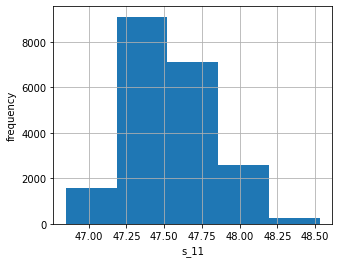

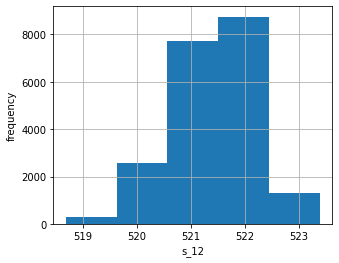

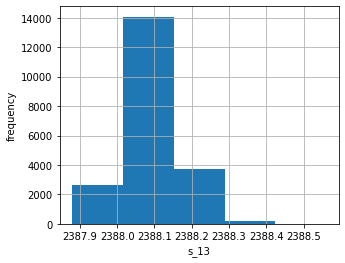

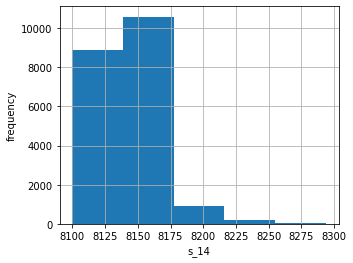

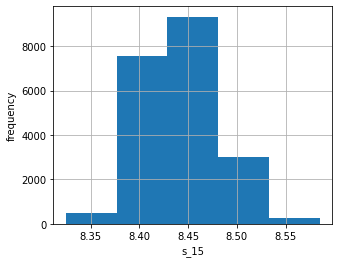

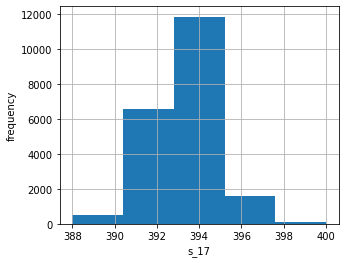

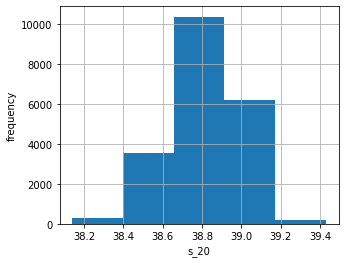

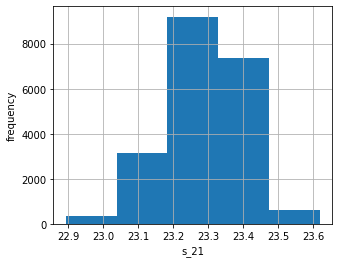

In [61]:
train_s_hist = train_copy[sensor_names].copy()
train_s_hist = train_s_hist.drop(sacar_sensores, axis=1)

for i in train_s_hist.columns:
    train_s_hist_graph = train_s_hist[i]
    train_s_hist_graph.hist(bins=5, figsize=(5,4))
    plt.xlabel(i)
    plt.ylabel('frequency')
    plt.show()

In [45]:
train_copy_v2 = train_copy.copy()
train_copy_v2['RUL'] = train_copy_v2['RUL'].clip(upper=130)
train_corr = train_copy_v2[sensor_names+['RUL']].copy()
train_corr = train_corr.drop(sacar_sensores, axis=1)
corr = train_corr.corr()

<AxesSubplot:>

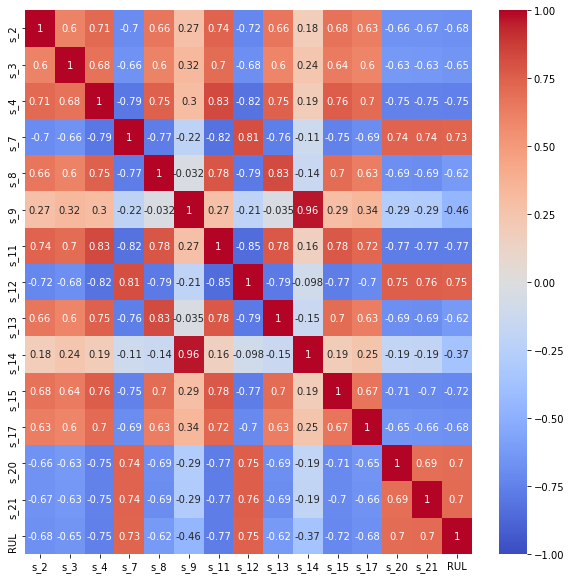

In [46]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)

In [47]:
new_variables = []
for i in corr[(corr['RUL']>=0.5) | (corr['RUL']<=-0.5)]['RUL'].index:
    new_variables += [i]
new_variables.remove('RUL')

In [48]:
#Nuevas variables de training
x_train = train_copy_v2[new_variables+['RUL']].copy()
y_train = x_train.pop('RUL')

#Actualizar variables para test
x_test = test_copy.groupby('unit_nr').last().reset_index()
x_test = x_test[new_variables].copy()
y_test = y_test_copy.copy()

In [49]:
norm = MinMaxScaler().fit(x_train)
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)

In [50]:
#Generamos la SVR
svr = SVR(kernel='linear')
svr.fit(x_train_norm,y_train)
yhat_train = svr.predict(x_train_norm)

#Aplicamos SVR al test
yhat_test = svr.predict(x_test_norm)

#Evaluamos con los kpis mencionados 
print("Testing con SVR con normalización:")
rmse(y_test,yhat_test)
r2(y_test,yhat_test)

Testing con SVR con normalización:
rmse:  22.718262641094405
R2:  0.701124243874728


El modelo no mejora al usar correlaciones así que se hará feature engineering.

#### Feature engineering
Se utilizarán combinaciones de polinomios para ver que variables utilizar

In [10]:
sacar_sensores = ['s_1','s_10','s_18','s_19','s_5','s_6','s_16']
train_copy_v2 = train_copy.copy()
train_copy_v2['RUL'] = train_copy_v2['RUL'].clip(upper=130)
#Nuevas variables de training
x_train = train_copy_v2[sensor_names+['RUL']].copy()
x_train = x_train.drop(sacar_sensores, axis=1)
y_train = x_train.pop('RUL')

#Actualizar variables para test
x_test = test_copy.groupby('unit_nr').last().reset_index()
x_test = x_test[sensor_names].copy()
x_test = x_test.drop(sacar_sensores, axis=1)
y_test = y_test_copy.copy()

norm = MinMaxScaler().fit(x_train)
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)

In [11]:
pf = PolynomialFeatures(2)
x_train_pf = pf.fit_transform(x_train_norm)
x_test_pf = pf.fit_transform(x_test_norm)

In [12]:
#Generamos la SVR + Feature Engineering (todas las combinaciones de polinomios)
svr = SVR(kernel='linear')
svr.fit(x_train_pf,y_train)

#Se hace la seleccion de variables donde utilizamos la media como parametro de importancia
fe_var = SelectFromModel(svr, threshold='mean',prefit=True)
fe_var.get_support()
fe_var_final = pf.get_feature_names()

print("Columnas previas:")
print(x_train.columns)
print("Columnas post:")
print(np.array(fe_var_final)[fe_var.get_support()])

Columnas previas:
Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')
Columnas post:
['x0' 'x1' 'x2' 'x3' 'x5' 'x6' 'x7' 'x9' 'x10' 'x11' 'x12' 'x13' 'x0 x9'
 'x2 x5' 'x2 x8' 'x2 x9' 'x3 x5' 'x3 x8' 'x3 x9' 'x4^2' 'x4 x6' 'x4 x7'
 'x4 x8' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x9' 'x5 x12' 'x5 x13' 'x6^2' 'x6 x8'
 'x6 x9' 'x7 x8' 'x7 x9' 'x8^2' 'x9^2' 'x9 x12' 'x9 x13']


In [13]:
#Generamos la SVR + Feature Engineering (todas las combinaciones de polinomios)
svr = SVR(kernel='linear')
x_train_pf_fil = x_train_pf[:,fe_var.get_support()]
svr.fit(x_train_pf_fil,y_train)
yhat_train = svr.predict(x_train_pf_fil)

#Aplicamos SVR al test
x_test_pf_fil = x_test_pf[:,fe_var.get_support()]
yhat_test = svr.predict(x_test_pf_fil)

#Evaluamos con los kpis mencionados 
print("Testing con SVR con selección de variables con Feature Engineering:")
rmse(y_test,yhat_test)
r2(y_test,yhat_test)

Testing con SVR con selección de variables con Feature Engineering:
rmse:  20.75215965918884
R2:  0.7506168789348862


In [21]:
yhat_test

array([129.67479242, 109.39582595,  75.88788649,  87.83546349,
        98.53810205, 101.54916038, 101.89296047,  86.70859101,
        96.20917429,  98.46420291,  88.07215144,  87.95687177,
        86.30615275, 103.93978964, 128.50966828, 110.27066018,
        62.72655422,  70.62318494, 103.52848996,  27.98282418,
        81.72027831, 118.59814097, 128.05746903,  24.95826952,
       119.22677436, 106.39943251, 113.47642842,  94.3213087 ,
        98.33337253,  86.87248751,  19.97859494,  68.3119616 ,
        91.81289244,   3.20754491,   3.37843173,  36.42339111,
        76.60022898,  57.10742851, 119.29193555,  40.20118085,
        84.16863303,  31.81872267,  72.86500296, 102.5809313 ,
        72.1224875 ,  60.46698823, 110.98020754, 101.98859181,
        23.3446385 , 103.57486772, 104.32202698,  37.87772611,
        42.66228653, 126.75669913, 116.82493944,  32.58257815,
        95.12495915,  60.32710672, 129.74791934, 101.52359111,
        51.08901143,  67.71767496,  74.53657995,  61.02

El modelo mejora alcanzando un rmse de 21 aprox. y R2 de 0.75 siendo el que se utilizará para la predicción.

In [24]:
resultados = pd.DataFrame()
resultados['unit_nr'] = test_copy.unit_nr.unique()
resultados['time_cycles'] = test_copy.groupby('unit_nr').last().reset_index()['time_cycles']
resultados['prediction_RUL'] = pd.DataFrame(yhat_test)
resultados

,unit_nr,time_cycles,prediction_RUL
0,1,31,129.674792
1,2,49,109.395826
2,3,126,75.887886
3,4,106,87.835463
4,5,98,98.538102
...,...,...,...
95,96,97,123.603935
96,97,134,85.225055
97,98,121,82.539455
98,99,97,120.092940


Si tomamos la data de train como la situación actual que buscásemos predecir, se podrían generar priorizaciones:

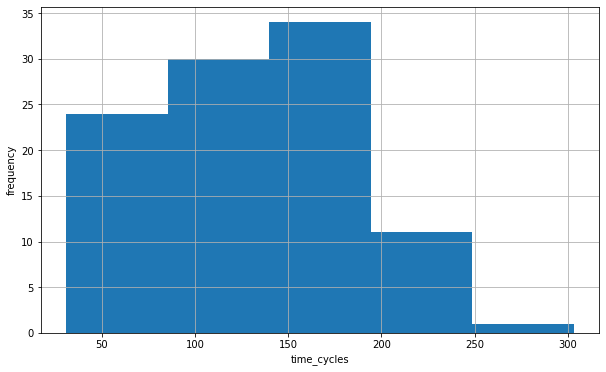

In [17]:
resultados_hist = resultados[['unit_nr','time_cycles']].groupby('unit_nr').max().reset_index()
resultados_hist['time_cycles'].hist(bins=5, figsize=(10,6))
plt.xlabel('time_cycles')
plt.ylabel('frequency')
plt.show()

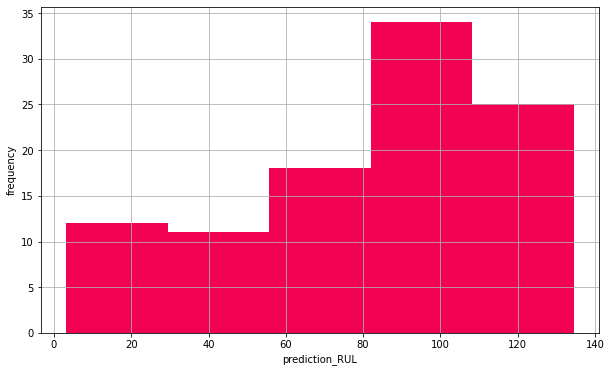

In [31]:
resultados_hist = resultados[['unit_nr','prediction_RUL']].groupby('unit_nr').max().reset_index()
resultados_hist['prediction_RUL'].hist(bins=5, figsize=(10,6), color='#F20253')
plt.xlabel('prediction_RUL')
plt.ylabel('frequency')
plt.show()

In [25]:
resultados.sort_values(by='prediction_RUL', ascending=True )

,unit_nr,time_cycles,prediction_RUL
33,34,203,3.207545
34,35,198,3.378432
80,81,213,5.323635
81,82,162,9.569507
75,76,205,12.449582
...,...,...,...
14,15,76,128.509668
0,1,31,129.674792
58,59,94,129.747919
72,73,112,131.027076
